<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/TutorialAlgorithmImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Creating Neuroevolution Algoritms

## Pre-requisite

Before we start, we need to install EvoJAX and import some libraries.  
**Note** In our [paper](https://arxiv.org/abs/2202.05008), we ran the experiments on NVIDIA V100 GPU(s). Your results can be different from ours.


In [1]:
from IPython.display import clear_output, Image

!pip install evojax

clear_output()

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp

from evojax.task.cartpole import CartPoleSwingUp
from evojax.policy.mlp import MLPPolicy
from evojax.algo import PGPE
from evojax import Trainer
from evojax.util import create_logger

In [3]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Neuroevolution algorithm creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-02-11 02:06:40,128 [INFO] Welcome to the tutorial on Neuroevolution algorithm creation!
absl: 2022-02-11 02:06:40,137 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
absl: 2022-02-11 02:06:40,322 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
EvoJAX: 2022-02-11 02:06:40,324 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


Tesla K80


## Introduction

EvoJAX has three major components: the *task*, the *policy network* and the *neuroevolution algorithm*. Once these components are implemented and instantiated, we can use a trainer to start the training process. The following code snippet provides an example of how we use EvoJAX.

In [4]:
seed = 42  # Wish me luck!

# We use the classic cart-pole swing up as our tasks, see
# https://github.com/google/evojax/tree/main/evojax/task for more example tasks.
# The test flag provides the opportunity for a user to
# 1. Return different signals as rewards. For example, in our MNIST example,
#    we use negative cross-entropy loss as the reward in training tasks, and the
#    classification accuracy as the reward in test tasks.
# 2. Perform reward shaping. It is common for RL practitioners to modify the
#    rewards during training so that the agent learns more efficiently. But this
#    modification should not be allowed in tests for fair evaluations.
hard = False
train_task = CartPoleSwingUp(harder=hard, test=False)
test_task = CartPoleSwingUp(harder=hard, test=True)

# We use a feedforward network as our policy.
# By default, MLPPolicy uses "tanh" as its activation function for the output.
policy = MLPPolicy(
    input_dim=train_task.obs_shape[0],
    hidden_dims=[64, 64],
    output_dim=train_task.act_shape[0],
    logger=logger,
)

# We use PGPE as our evolution algorithm.
# If you want to know more about the algorithm, please take a look at the paper:
# https://people.idsia.ch/~juergen/nn2010.pdf 
solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

# Now that we have all the three components instantiated, we can create a
# trainer and start the training process.
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=600,
    log_interval=100,
    test_interval=200,
    n_repeats=5,
    n_evaluations=128,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-11 02:06:43,518 [INFO] MLPPolicy.num_params = 4609
EvoJAX: 2022-02-11 02:06:43,687 [INFO] Start to train for 600 iterations.
EvoJAX: 2022-02-11 02:07:10,038 [INFO] Iter=100, size=64, max=712.8441, avg=631.1234, min=378.0512, std=64.7720
EvoJAX: 2022-02-11 02:07:29,392 [INFO] Iter=200, size=64, max=782.5107, avg=728.4261, min=583.6249, std=34.0188
EvoJAX: 2022-02-11 02:07:31,972 [INFO] [TEST] Iter=200, #tests=128, max=816.3523 avg=783.4709, min=740.3708, std=13.4363
EvoJAX: 2022-02-11 02:07:51,419 [INFO] Iter=300, size=64, max=920.6417, avg=896.7332, min=535.2375, std=57.9114
EvoJAX: 2022-02-11 02:08:10,756 [INFO] Iter=400, size=64, max=921.8397, avg=876.6884, min=503.6208, std=97.4690
EvoJAX: 2022-02-11 02:08:10,907 [INFO] [TEST] Iter=400, #tests=128, max=934.5466 avg=923.8679, min=893.9545, std=5.7070
EvoJAX: 2022-02-11 02:08:30,258 [INFO] Iter=500, size=64, max=932.7117, avg=885.1906, min=465.1427, std=102.7106
EvoJAX: 2022-02-11 02:08:49,644 [INFO] [TEST] Iter=600, #

reward=[940.53296]


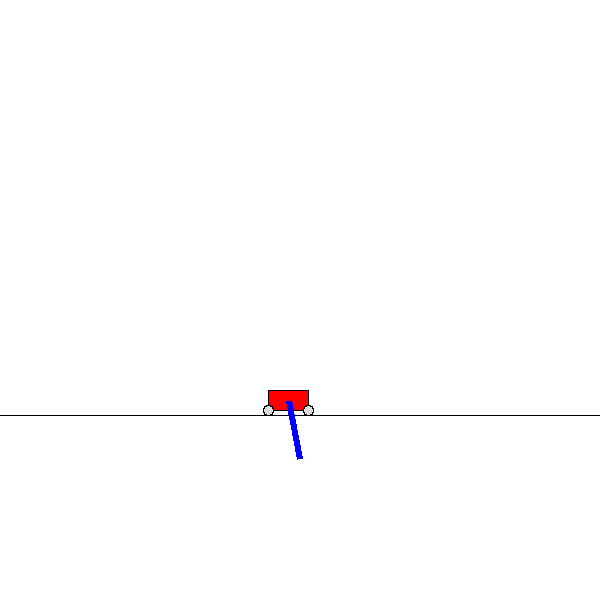

In [5]:
# Let's visualize the learned policy.

def render(task, algo, policy):
    """Render the learned policy."""

    task_reset_fn = jax.jit(test_task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(test_task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [CartPoleSwingUp.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, d = step_fn(task_s, act)
        step += 1
        reward = reward + r
        done = bool(d[0])
        if step % 3 == 0:
            images.append(CartPoleSwingUp.render(task_s, 0))
    print('reward={}'.format(reward))
    return images


imgs = render(test_task, solver, policy)
gif_file = os.path.join(log_dir, 'cartpole.gif')
imgs[0].save(
    gif_file, save_all=True, append_images=imgs[1:], duration=40, loop=0)
Image(open(os.path.join(log_dir, 'cartpole.gif'),'rb').read())

This tutorial walks you through the process of creating a new neuroevolution algoritm.  

To contribute an algorithm implementation to EvoJAX, all you need to do is to implement the `NEAlgorithm` interface.  
The interface is defined as the following and you can see the related Python file [here](https://github.com/google/evojax/blob/main/evojax/algo/base.py):
```python
class NEAlgorithm(ABC):
    """Interface of all Neuro-evolution algorithms in EvoJAX."""

    pop_size: int

    @abstractmethod
    def ask(self) -> jnp.ndarray:
        """Ask the algorithm for a population of parameters.
        Returns
            A Jax array of shape (population_size, param_size).
        """
        raise NotImplementedError()

    @abstractmethod
    def tell(self, fitness: Union[np.ndarray, jnp.ndarray]) -> None:
        """Report the fitness of the population to the algorithm.
        Args:
            fitness - The fitness scores array.
        """
        raise NotImplementedError()

    @property
    def best_params(self) -> jnp.ndarray:
        raise NotImplementedError()

    @best_params.setter
    def best_params(self, params: Union[np.ndarray, jnp.ndarray]) -> None:
        raise NotImplementedError()
```

## Wrap an existing implementation

`NEAlgorithm` adopts the well-known “ask” and “tell” interfaces, where the former requests the algorithm to generate a population of parameters and the latter reports the parameters' fitness scores so that the algorithm can update its internal states. We think the conventional interface for the neuroevolution algorithms brings familiarity to the developers and thus reduces the required learning effort. Moreover, the interface is also used by many existing algorithms, it is therefore possible for the practitioners to quickly plug in existing algorithms for sanity checks. In the first part of this tutorial, we will create an implementation that wraps [CMA-ES](https://github.com/CMA-ES/pycma). Please take a look at this wonderful [tutorial](https://arxiv.org/abs/1604.00772) for more information about CMA-ES.

In [6]:
import cma
from evojax.algo.base import NEAlgorithm


class CMAWrapper(NEAlgorithm):
    """This is a wrapper of CMA-ES."""

    def __init__(self, param_size, pop_size, init_stdev=0.1, seed=0):
        
        self.pop_size = pop_size
        self.params = None
        self._best_params = None

        # We create CMA-ES in a simplest form.
        self.cma = cma.CMAEvolutionStrategy(
            x0=np.zeros(param_size),
            sigma0=init_stdev,
            inopts={
                'popsize': pop_size,
                'seed': seed if seed > 0 else 42,
                'randn': np.random.randn,
            },
        )
        
        # We jit-compile some utility functions.
        self.jnp_array = jax.jit(jnp.array)
        self.jnp_stack = jax.jit(jnp.stack)

    def ask(self):
        self.params = self.cma.ask()
        return self.jnp_stack(self.params)

    def tell(self, fitness):
        # CMA-ES minimizes, so we negate the fitness.
        self.cma.tell(self.params, -np.array(fitness))
        self._best_params = np.array(self.cma.result.xfavorite)

    @property
    def best_params(self):
        return self.jnp_array(self._best_params)

    @best_params.setter
    def best_params(self, params):
        self._best_params = np.array(params)

Notice that our implementation above is extremely simple, we haven't used many options or functions provided by CMA-ES.  
But let's plug in this implementation to our cart-pole earlier example and see how it works.  
<font color='red'>**Alert**</font> Depending on your CPUs, running the following cell may take some time.

In [7]:
# Instead of PGPE, we use our CMAWrapper now.
solver = CMAWrapper(
    pop_size=64,
    param_size=policy.num_params,
    seed=seed,
)
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=600,
    log_interval=100,
    test_interval=200,
    n_repeats=5,
    n_evaluations=128,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-11 02:08:59,845 [INFO] Start to train for 600 iterations.


(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4609 (seed=42, Fri Feb 11 02:08:59 2022)


EvoJAX: 2022-02-11 02:14:31,792 [INFO] Iter=100, size=64, max=643.9105, avg=435.9338, min=90.4372, std=132.2541
EvoJAX: 2022-02-11 02:20:00,840 [INFO] Iter=200, size=64, max=692.3575, avg=518.4102, min=78.3178, std=97.0893
EvoJAX: 2022-02-11 02:20:01,894 [INFO] [TEST] Iter=200, #tests=128, max=751.8185 avg=669.0272, min=660.6714, std=8.4904
EvoJAX: 2022-02-11 02:25:27,575 [INFO] Iter=300, size=64, max=718.8022, avg=532.3811, min=66.3884, std=139.0490
EvoJAX: 2022-02-11 02:31:06,983 [INFO] Iter=400, size=64, max=747.0325, avg=580.4314, min=121.3414, std=111.2562
EvoJAX: 2022-02-11 02:31:07,139 [INFO] [TEST] Iter=400, #tests=128, max=706.6234 avg=697.6046, min=689.8448, std=2.3396
EvoJAX: 2022-02-11 02:36:32,660 [INFO] Iter=500, size=64, max=725.8452, avg=616.8888, min=427.4442, std=70.0661
EvoJAX: 2022-02-11 02:41:55,297 [INFO] [TEST] Iter=600, #tests=128, max=764.3683, avg=743.6188, min=721.2967, std=9.2470
EvoJAX: 2022-02-11 02:41:55,305 [INFO] Training done, best_score=743.6188


The simple CMA-ES wrapper worked! However, we also notice that the training time increased significantly.  
Although the task and the policy networks are accelerated by GPUs, the `cma.CMAEvolutionStrategy` implementation we used in the code above relies on CPUs, and that is why we see the drop in training speed.  

Nevertheless, being able to wrapper an existing algorithm and plug that in EvoJAX's training pipeline serves as sanity checks and helps debugging when you migrate algorithms to EvoJAX. Next, we will show you how to implement an algorithm in JAX from scratch.

## Simple PGPE in JAX

We are going to implement a very simple version of PGPE, users interested in the algorithm can take a look at the [paper](https://people.idsia.ch/~juergen/icann2008sehnke.pdf) and also check out some popular implementations ([example1](https://github.com/hardmaru/estool/blob/b0954523e906d852287c6f515f34756c550ccf42/es.py#L352), [example2](https://github.com/nnaisense/pgpelib)).

In a nutshell, PGPE samples the policy network parameters $\theta$ from Gaussian distributions. It maintains the means $\mu$ and the standard deviations $\sigma$ of the Gaussian distributions, and then estimates the gradients of these parameters using the following formulae:

$\Delta \mu_i = \alpha (r - b) (\theta_i - \mu_i)$ ,
$\Delta \sigma_i = \alpha (r - b) \frac{(\theta_i - \mu_i)^2 - {\sigma_i}^2}{\sigma_i}$

where $\alpha$ is the learning rate and $b$ is a baseline from the reward $r$.

The following code snippet provides a sample implementation of PGPE.  
**Note** This simplified version ignores popular tricks such as converting the rewards to ranks, using modern optimizers for parameter update, etc.

In [8]:
from evojax.algo.base import NEAlgorithm


class SimplePGPE(NEAlgorithm):
    """A simplified version of PGPE."""

    def __init__(self, param_size, pop_size,
                 lr_mu=0.05, lr_sigma=0.1, init_stdev=0.1, seed=0):
        
        self.pop_size = pop_size
        assert pop_size % 2 == 0, "pop_size must be a multpile of 2."
        n_directs = pop_size // 2
        self.noises = jnp.zeros(param_size)
        self.params = jnp.zeros(param_size)
        self.mu = jnp.zeros(param_size)
        self.sigma = jnp.ones(param_size) * init_stdev
        self.rand_key = jax.random.PRNGKey(seed=seed)
        
        def ask_fn(key, mu, sigma):
            next_key, sample_key = jax.random.split(key=key, num=2)
            perturbations = jax.random.normal(
                key=sample_key, shape=(n_directs, param_size)) * sigma[None, :]
            params = jnp.vstack([perturbations, -perturbations]) + mu[None, :]
            return params, perturbations, next_key

        self.ask_fn = jax.jit(ask_fn)

        def tell_fn(rewards, mu, sigma, perturbations):            
            fitness = jnp.array(rewards).reshape([2, n_directs])
            
            # To map to the formulae above:
            # (r - b) = (avg_fitness - b) and (theta - mu) = perturbations
            avg_fitness = fitness.mean(axis=0)
            b = jnp.mean(fitness)

            # Update the means.
            grad_mu = (
                (avg_fitness - b)[:, None] * perturbations
            ).mean(axis=0)
            new_mu = mu + lr_mu * grad_mu

            # Update the sigmas.
            # We constrain the change of sigma to prevent numerical errors.
            grad_sigma = (
                (avg_fitness - b)[:, None] *
                (perturbations ** 2 - (sigma ** 2)[None, :]) / sigma[None, :]
            ).mean(axis=0)
            new_sigma = jnp.clip(
                sigma + lr_sigma * grad_sigma, 0.8 * sigma, 1.2 * sigma)
            
            return new_mu, new_sigma

        self.tell_fn = jax.jit(tell_fn)

    def ask(self):
        self.params, self.noises, self.rand_key = self.ask_fn(
            self.rand_key, self.mu, self.sigma)
        return self.params

    def tell(self, fitness):
        self.mu, self.sigma = self.tell_fn(
            fitness, self.mu, self.sigma, self.noises)

    @property
    def best_params(self):
        return self.mu

    @best_params.setter
    def best_params(self, params):
        self.mu = jnp.array(params)

In [9]:
# Let's test our simple PGPE.
solver = SimplePGPE(
    pop_size=64,
    param_size=policy.num_params,
    seed=seed,
)
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=1000,
    log_interval=100,
    test_interval=200,
    n_repeats=5,
    n_evaluations=128,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-02-11 02:41:55,585 [INFO] Start to train for 1000 iterations.
EvoJAX: 2022-02-11 02:42:16,350 [INFO] Iter=100, size=64, max=413.9725, avg=121.4492, min=9.4152, std=105.6984
EvoJAX: 2022-02-11 02:42:35,561 [INFO] Iter=200, size=64, max=512.9973, avg=368.1396, min=83.2550, std=96.9921
EvoJAX: 2022-02-11 02:42:36,577 [INFO] [TEST] Iter=200, #tests=128, max=556.6218 avg=304.6777, min=79.5980, std=109.6013
EvoJAX: 2022-02-11 02:42:55,783 [INFO] Iter=300, size=64, max=523.7679, avg=431.6786, min=296.3107, std=48.0662
EvoJAX: 2022-02-11 02:43:14,984 [INFO] Iter=400, size=64, max=567.3138, avg=508.6823, min=354.7345, std=45.3495
EvoJAX: 2022-02-11 02:43:15,137 [INFO] [TEST] Iter=400, #tests=128, max=585.5190 avg=472.7958, min=5.9336, std=87.1573
EvoJAX: 2022-02-11 02:43:34,341 [INFO] Iter=500, size=64, max=586.1516, avg=553.2451, min=522.9246, std=11.5906
EvoJAX: 2022-02-11 02:43:53,552 [INFO] Iter=600, size=64, max=567.7144, avg=537.9158, min=500.7575, std=12.0417
EvoJAX: 2022-02

Despite its simplicity, the training and test scores rise steadily. You can see our complete implementation of PGPE [here](https://github.com/google/evojax/blob/main/evojax/algo/pgpe.py).  

We hope this tutorial helps. Please let us (evojax-dev@google.com) know if you have any problems or suggestions, thanks!